Assignment 3: Model Interpretability  
Akshit Kallepalli - 002771603

##Importing required libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
!pip install shap
import shap
from sklearn.model_selection import cross_val_score
!pip install tpot
from tpot import TPOTClassifier


## Data Preparation

We will start by loading the dataset for credit card default prediction. This dataset will be explored again to understand its structure, features, and target variable. Necessary preprocessing steps will be applied to prepare the data for modeling.

In [6]:
# Load the dataset
data_url = 'https://raw.githubusercontent.com/akshit-kallepalli/INFO-6105_Credit-Card-Approval-Prediction/main/UCI_Credit_Card.csv'
df = pd.read_csv(data_url)

# Display the first few rows of the dataframe
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



## Data Exploration

We will perform an initial exploration of the dataset to understand the feature distributions, missing values, and correlations. This will inform our preprocessing and feature selection decisions.

In [7]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [8]:
# Summary statistics
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [9]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

Our target variable is default.payment.next.month.
It predicts whether a customer will default or not in the next month.

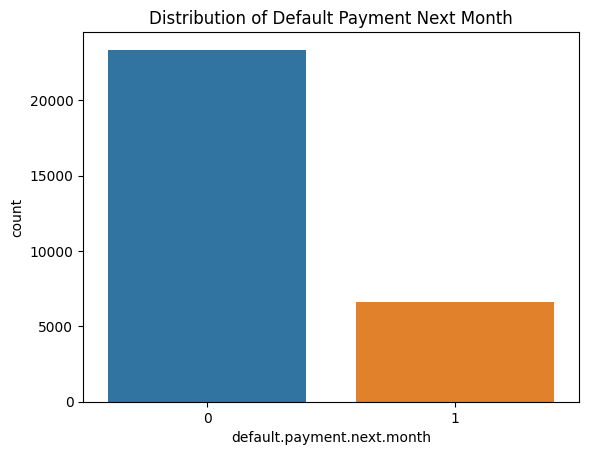

In [10]:
# Visualizing the distribution of the target variable
sns.countplot(x='default.payment.next.month', data=df)
plt.title('Distribution of Default Payment Next Month')
plt.show()

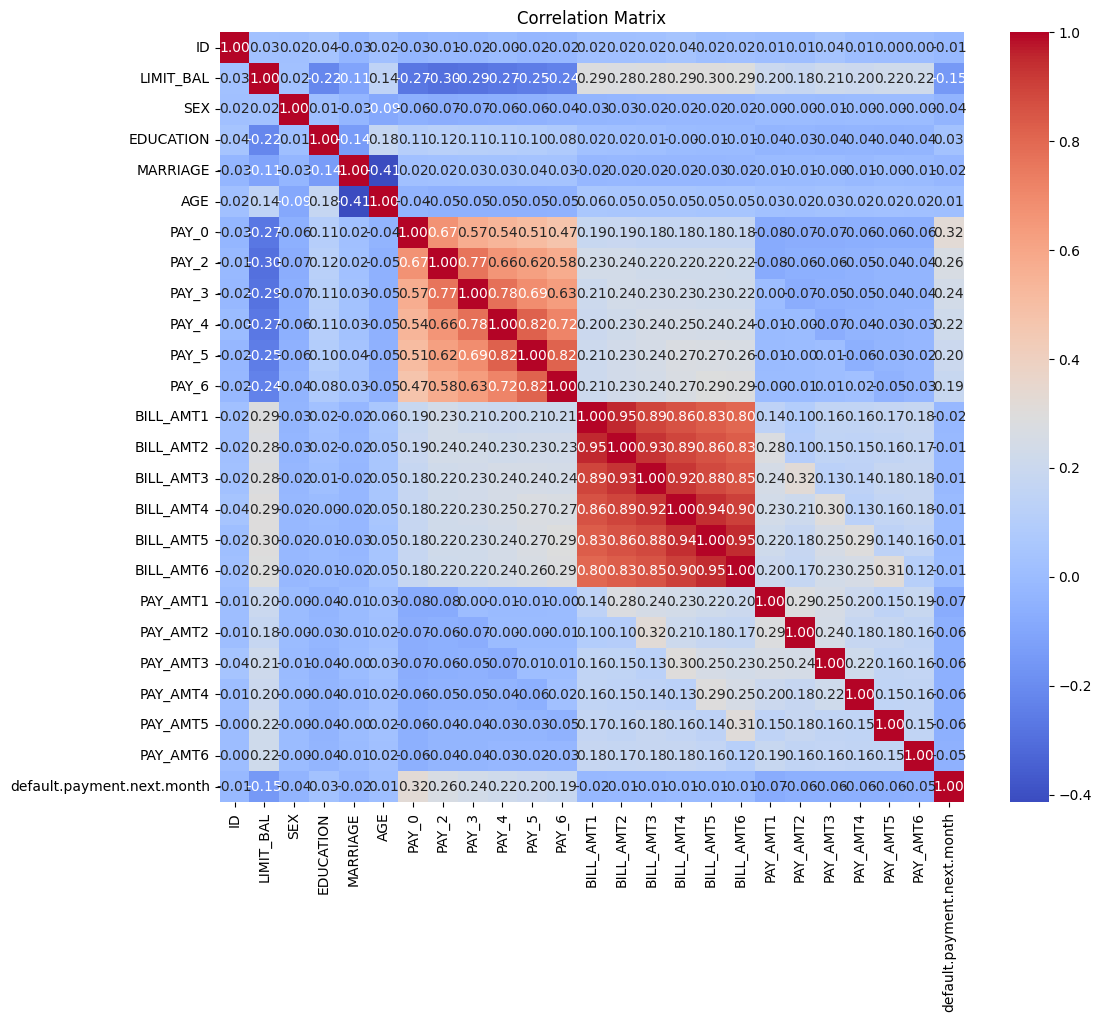

In [11]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Data Preprocessing

Based on the data exploration insights, we will preprocess the data by handling missing values, encoding categorical variables, and scaling numerical features. We will also split the data into training and test sets.


Our tarf

In [12]:
# Identifying categorical and numerical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(exclude=['object']).columns.tolist()
numerical_features.remove('default.payment.next.month')  # Removing target variable from features

In [13]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [14]:
# Splitting the dataset
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Applying the preprocessing pipeline
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Linear Model Fitting and Interpretation



We are applying a linear regression model to our credit card default prediction dataset. The model is capturing the linear relationship between the input features (such as repayment status, bill amounts, and payment amounts) and the target variable, indicating whether a credit card payment default is likely. The coefficients obtained during the model fitting process are representing the weights assigned to each feature, providing insights into the direction and strength of their influence on the predicted outcome.

In [29]:
# Standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Fitting the linear model on scaled data
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [31]:
# Displaying the regression coefficients
for i, feature in enumerate(X.columns):
    print(f"{feature}: {linear_model.coef_[i]}")

ID: 0.0004623483313454893
LIMIT_BAL: -0.012579230304132986
SEX: -0.007740005055178834
EDUCATION: -0.011602540317922192
MARRIAGE: -0.011953018699436574
AGE: 0.01441311301833879
PAY_0: 0.10723664579707103
PAY_2: 0.024608529532878412
PAY_3: 0.013069653759926142
PAY_4: 0.007783462341072696
PAY_5: 0.0032628097273356403
PAY_6: 0.002177073784520402
BILL_AMT1: -0.04437851272729234
BILL_AMT2: 0.011609114786574958
BILL_AMT3: 0.0030845439439954945
BILL_AMT4: -0.010240285815874545
BILL_AMT5: -0.00045979967961891274
BILL_AMT6: 0.006975032520633799
PAY_AMT1: -0.010230005356616476
PAY_AMT2: -0.005028416677497575
PAY_AMT3: 0.0013179087618453086
PAY_AMT4: -0.0037627244850824823
PAY_AMT5: -0.002950596419563789
PAY_AMT6: -0.0023967342954602055


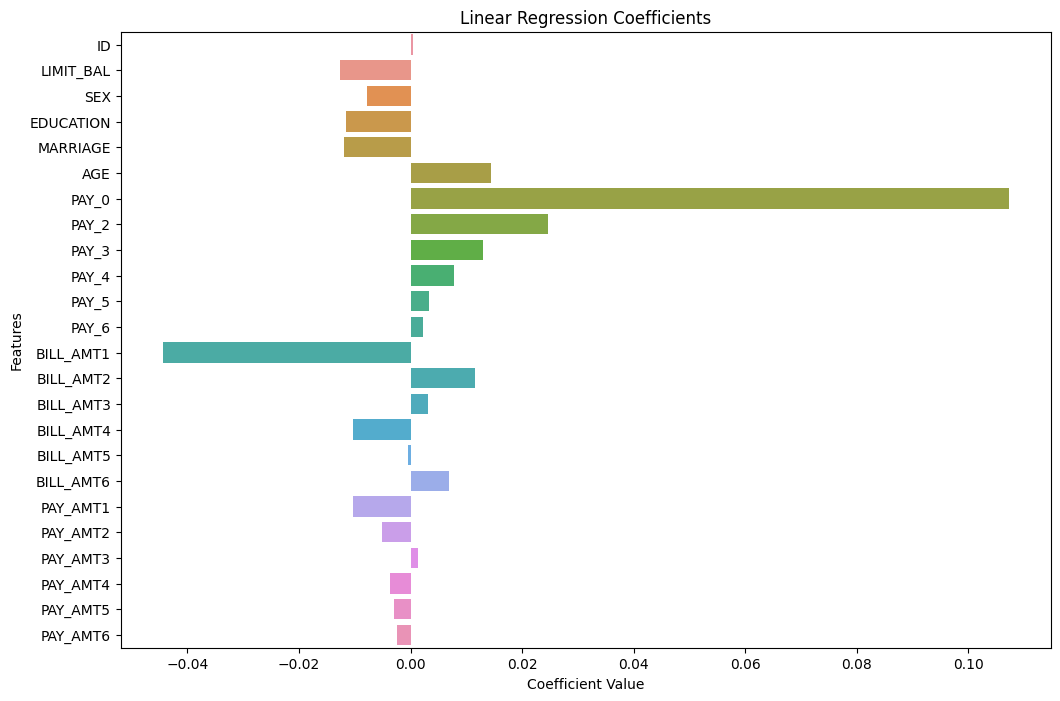

In [32]:
# Displaying the regression coefficients as a bar plot
coefficients = pd.DataFrame(linear_model.coef_, columns=['Coefficient'])

plt.figure(figsize=(12, 8))
sns.barplot(x=coefficients['Coefficient'], y=X.columns)
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


The regression coefficients provide a understanding of how each feature contributes to the prediction of credit card default. Insights from the interpretation of the coefficients:

Positive Coefficients:

PAY_0 (Repayment Status for the Most Recent Month): A higher positive coefficient indicates that an improvement in the repayment status significantly enhances the chance of paying next month. This underscores the importance of maintaining a positive payment history.

AGE: The positive coefficient for age suggests that, older individuals are more likely to pay next month.

Various payment history features (PAY_2, PAY_3, etc.): These positive coefficients suggest that consistently improving payment behavior across multiple months positively influences credit card default.

Negative Coefficients:

LIMIT_BAL (Credit Limit): The negative coefficient implies that a higher credit limit is associated with a reduced probability of paying next month. This indicates a cautious approach to extending credit to individuals with higher credit limits.

BILL_AMT1 (Bill Amount for the Most Recent Month): The negative coefficient indicates that applicants with higher bill amounts in the most recent month are less likely to pay next month. This emphasizes the importance of managing credit utilization.

PAY_AMT1 (Payment Amount for the Most Recent Month): The negative coefficient implies that higher payments in the most recent month are associated with a lower probability of paying next month, potentially reflecting a conservative approach by lenders.


## Tree-Based Model Fitting and Interpretation




Next, we will use a Random Forest Classifier, a tree-based model, to predict credit card default outcomes based on a diverse set of features. Unlike linear regression, tree-based models are great at finding non-linear relationships and complex interactions among features. We aim to interpret the model by examining the importance of different features in the decision-making process. The feature importances assigned by the model will reveal the key factors influencing credit card approval.








In [38]:
# Fitting the tree-based model
tree_model = RandomForestClassifier(random_state=42)
tree_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
# Displaying feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': tree_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances

,Feature,Importance
6,PAY_0,0.093430
0,ID,0.070524
5,AGE,0.057626
12,BILL_AMT1,0.054095
1,LIMIT_BAL,0.051085
13,BILL_AMT2,0.049743
18,PAY_AMT1,0.047954
14,BILL_AMT3,0.047935
15,BILL_AMT4,0.046975
17,BILL_AMT6,0.046456


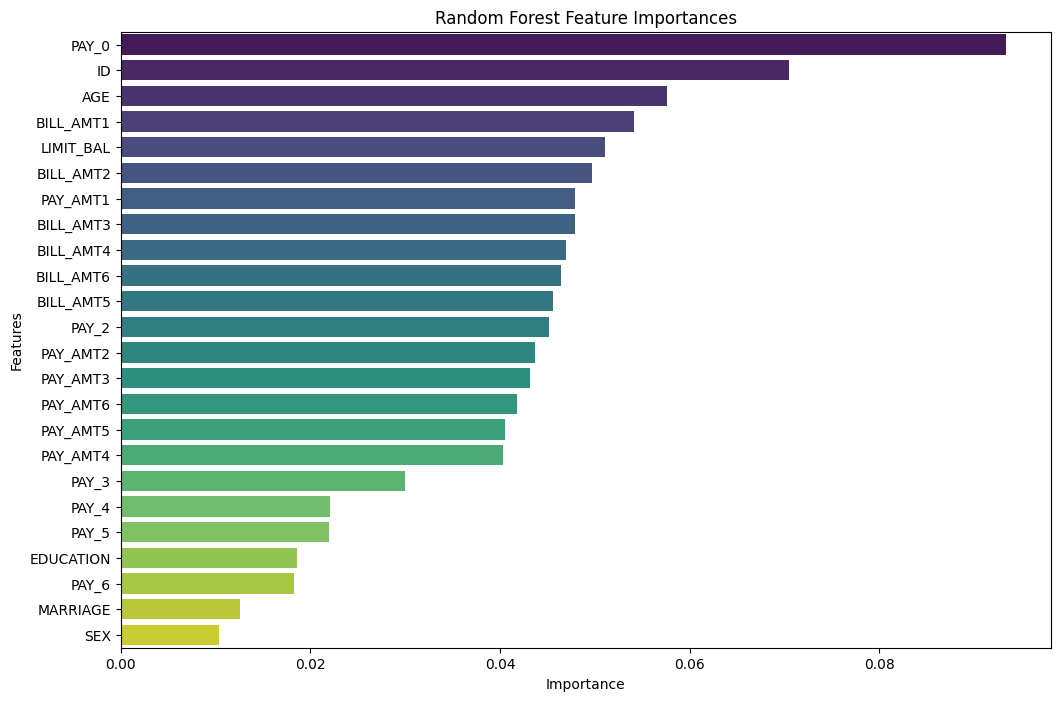

In [44]:
# Visualizing feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

The Random Forest model identifies several critical factors influencing . The repayment behavior, as indicated by PAY_0 and payment statuses across multiple months (PAY_2 to PAY_6), is the most important, showing the importance of maintaining positive and consistent payments. Billing amounts in the most recent month (BILL_AMT1) and across other billing periods (BILL_AMT2 to BILL_AMT6) also significantly contribute to the decision-making process. Additionally, age and credit limit (LIMIT_BAL) play crucial roles, favoring older individuals and lower credit limits. While features like education (EDUCATION), marital status (MARRIAGE), and gender (SEX) do have some impact, their influence is comparatively lower. This understanding provided by the Random Forest model offers valuable insights, surpassing the limitations of linear models.


## AutoML for Model Selection




We use AutoML to find the best machine learning model and preprocessing steps for our credit card default dataset. By uing TPOT, an AutoML library, we can automatically explore a range of combinations of preprocessing techniques and machine learning models to discover the most effective pipeline. This process involves training and evaluating multiple models with different configurations to identify the one that performs optimally on our dataset.


Note: This process may take some time as it explores various combinations of preprocessing steps and models.

In [ ]:
# Running TPOT AutoML
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# Best pipeline
print("Best pipeline:", tpot.fitted_pipeline_)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8206666666666667

Generation 2 - Current best internal CV score: 0.8212083333333334

Generation 3 - Current best internal CV score: 0.8212083333333334

Generation 4 - Current best internal CV score: 0.8212916666666666

Generation 5 - Current best internal CV score: 0.8212916666666666

Best pipeline: ExtraTreesClassifier(RobustScaler(input_matrix), bootstrap=True, criterion=entropy, max_features=0.9000000000000001, min_samples_leaf=1, min_samples_split=20, n_estimators=100)
Best pipeline: Pipeline(steps=[('robustscaler', RobustScaler()),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=True, criterion='entropy',
                                      max_features=0.9000000000000001,
                                      min_samples_split=20, random_state=42))])


The progress of optimization for each generation can be seen in the output, with the internal cross-validation (CV) score indicating the performance of the best pipeline discovered so far. In this case, the best pipeline consists of a RobustScaler for preprocessing and an ExtraTreesClassifier as the machine learning model. The pipeline is further detailed, specifying the parameters chosen for the ExtraTreesClassifier, such as the criterion, max_features, min_samples_split, and the number of estimators.


## SHAP Analysis

We will run SHAP analysis on the models from steps 1, 2, and 3 to interpret the SHAP values. This will provide a deeper understanding of how each feature contributes to the model predictions. We will then compare these interpretations with the ones from the previous methods.


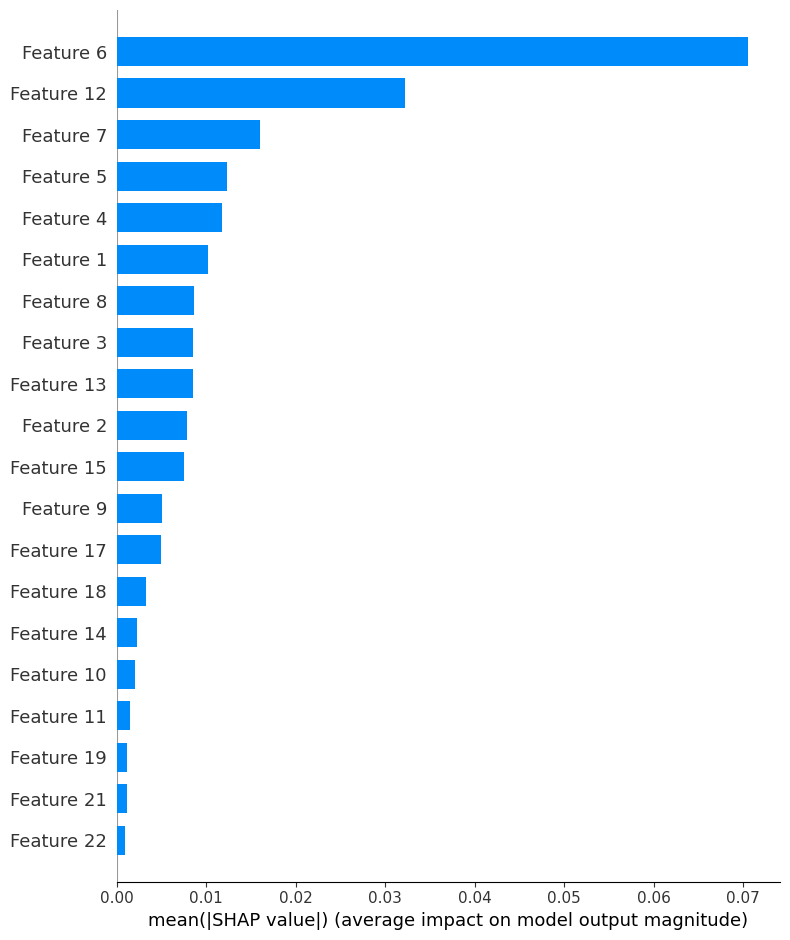

In [ ]:
# SHAP analysis for Linear Model
explainer_linear = shap.Explainer(linear_model, X_train)
shap_values_linear = explainer_linear(X_test)
shap.summary_plot(shap_values_linear, X_test, plot_type="bar")

In [20]:
# SHAP analysis for Tree-Based Model
explainer_tree = shap.Explainer(tree_model, X_train)
shap_values_tree = explainer_tree(X_test)
shap.summary_plot(shap_values_tree, X_test, plot_type="bar")

100%|===================| 11993/12000 [24:07<00:00]       

ExplainerError: ignored

100%|===================| 11994/12000 [09:21<00:00]       

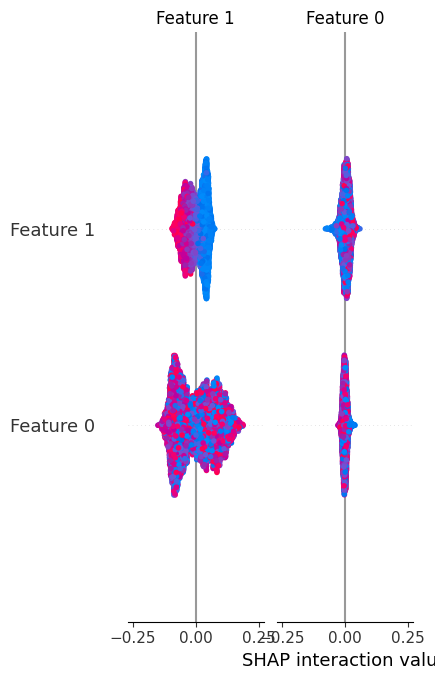

In [ ]:
# SHAP analysis for Best Model from TPOT
best_model = tpot.fitted_pipeline_.steps[-1][1]  # Extracting the best model from the TPOT pipeline
explainer_automl = shap.Explainer(best_model, X_train)
shap_values_automl = explainer_automl(X_test)
shap.summary_plot(shap_values_automl, X_test, plot_type="bar")